In [1]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import date
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA

/Users/KenLu/anaconda/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
SEED = 1990
N_DAYS = 954
N_CLUSTERS = 5
N_COMPONENTS = 29
# TIMESERIES_SZ = 300
N_TEST_DATA = 400
VAR_PERCENTILE_LEVEL = 5
METRIC = "dtw"
# METRIC = "euclidean"
FONT = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

In [3]:
connection = pg.connect(database="postgres", user="postgres", password="Crypto01", host="localhost", port=5430)
cur = connection.cursor()

In [4]:
cur.execute("SELECT * FROM input.crypto_daily_changes ORDER BY date DESC LIMIT %s" % str(N_DAYS))
data = sorted(cur.fetchall(), key=lambda row: row[0], reverse=False)
daily_changes = pd.DataFrame(data=data, columns=[desc[0] for desc in cur.description], index=[row[0] for row in data], dtype="float64")
daily_changes = daily_changes.drop(["date"], axis=1)
daily_changes = daily_changes[daily_changes.index <= date(2018, 7, 31)]
daily_changes = daily_changes - 1
transpose_df = daily_changes.transpose()

In [19]:
daily_changes

,AEON,BAY,BLOCK,BTC,BTCD,BURST,CRW,DASH,DGB,DOGE,...,NLG,POT,PPC,RDD,SYS,VIA,VTC,XCP,XMR,XRP
2016-01-01,0.030949,-0.296502,-0.265306,0.009396,-0.032787,0.000000,0.000000,0.177778,-0.062635,-0.002770,...,0.002935,0.024551,-0.014493,0.000000,-0.047174,0.023584,-0.022796,-0.038405,0.108141,0.056676
2016-01-02,-0.073431,0.000000,0.180451,-0.000622,0.000000,0.000000,0.000000,0.079137,0.000000,-0.061111,...,0.073206,0.039838,0.007353,0.000000,-0.069391,-0.012457,0.024378,-0.033988,-0.153010,-0.001364
2016-01-03,0.002903,-0.085601,-0.036252,-0.006963,0.008547,0.055462,0.877547,0.033210,0.000000,0.000000,...,0.014423,0.000000,-0.002433,0.249565,0.042480,0.154865,0.010709,-0.025285,0.059783,0.014634
2016-01-04,-0.097052,0.124730,0.009491,0.006083,-0.058824,0.000000,0.000000,-0.035714,-0.033077,0.103704,...,-0.087483,0.046157,0.000000,-0.200277,0.020250,0.094673,-0.018054,0.048847,-0.035897,-0.019231
2016-01-05,0.069600,-0.110825,-0.066132,-0.004892,-0.035714,0.157818,0.000000,0.096296,0.069600,0.047337,...,-0.003704,0.022169,-0.004878,0.000000,-0.029917,-0.085629,0.014887,-0.005219,0.000000,-0.019608
2016-01-06,-0.032934,0.031182,-0.042945,-0.000881,-0.009259,0.000000,0.000000,-0.034483,-0.032934,0.022599,...,0.051339,-0.028724,-0.007353,0.000000,0.010290,-0.006078,-0.067848,0.058813,0.000000,0.000000
2016-01-07,-0.029905,0.242706,-0.003323,0.060884,0.000000,-0.091352,0.841309,-0.040741,0.000000,-0.038122,...,0.006004,-0.036953,0.046914,0.250000,0.020317,-0.018178,-0.054275,-0.097553,0.000000,0.000000
2016-01-08,-0.071374,0.170705,-0.009486,-0.009146,0.017699,-0.099923,-0.009492,-0.040000,0.000000,-0.020678,...,-0.018072,0.046203,-0.023585,-0.200088,-0.030029,0.011395,-0.040984,-0.001568,0.159574,0.000000
2016-01-09,-0.110744,0.166822,-0.127653,-0.010069,-0.017544,0.111029,-0.007721,-0.056818,0.466914,0.045306,...,-0.022023,0.014761,0.007246,0.250418,0.020464,-0.041657,-0.007484,0.003174,-0.137615,-0.200000
2016-01-10,-0.320542,-0.285714,-0.124371,-0.004729,0.000000,-0.150045,0.000000,0.293860,0.091187,-0.113422,...,-0.018388,-0.057983,-0.002398,-0.199910,-0.040299,0.111695,0.070513,-0.004769,0.002128,0.000000


<Figure size 432x288 with 0 Axes>

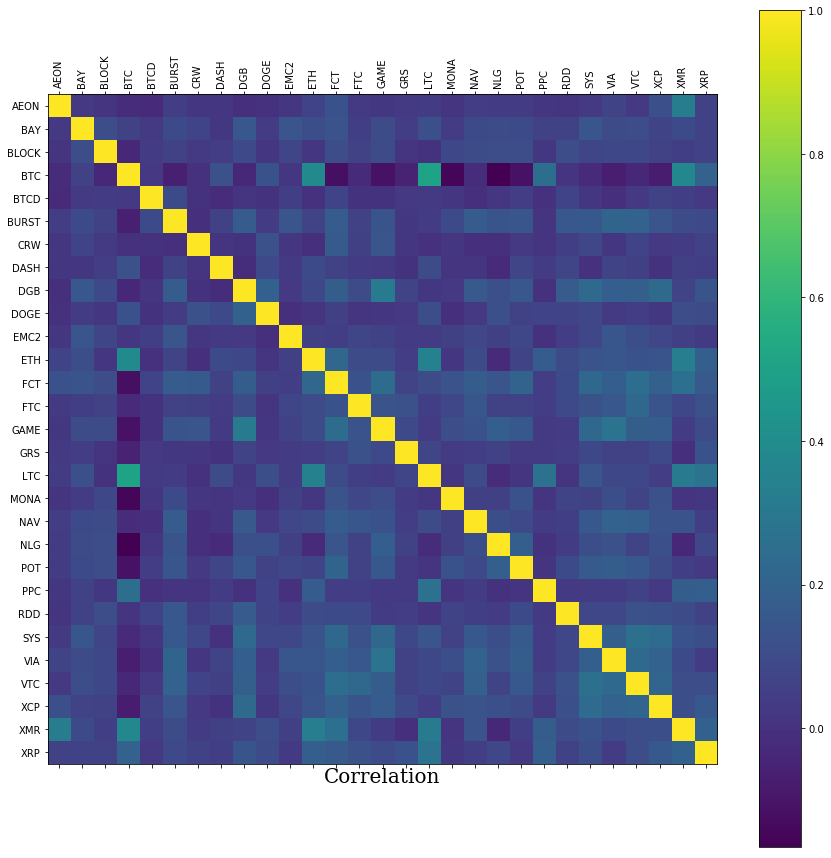

In [5]:
corr_mat = daily_changes.corr()
cryptos = np.array(corr_mat.columns)
plt.clf()
plt.rcParams['figure.figsize'] = [20, 15]
plt.matshow(corr_mat)
plt.xticks(range(len(cryptos)), cryptos, rotation="vertical")
plt.yticks(range(len(cryptos)), cryptos)
plt.xlabel("Correlation", fontdict=FONT)
plt.colorbar()
plt.show()

In [6]:
training_data = np.array(transpose_df)
# training_data = TimeSeriesResampler(sz=TIMESERIES_SZ).fit_transform(training_data)
# training_data = normalize(training_data, norm="l2")
pca = PCA(n_components=N_COMPONENTS)
training_data = pca.fit_transform(training_data)
dba_km = TimeSeriesKMeans(n_clusters=N_CLUSTERS, max_iter=100, metric=METRIC, verbose=True, max_iter_barycenter=10, random_state=SEED)
pred_clusters = dba_km.fit_predict(training_data)

5.067 --> 2.987 --> 2.897 --> 2.839 --> 2.809 --> 2.809 --> 


In [7]:
print("Percentage of interpretation:", sum(pca.explained_variance_ratio_))

Percentage of interpretation: 1.0


In [8]:
training_clusterList = {}
training_varList = {}
test_clusterList = {}
test_varList = {}

In [9]:
training_list = transpose_df.iloc[:, N_TEST_DATA:]
training_var = [np.percentile(row, VAR_PERCENTILE_LEVEL) for row in np.array(training_list)]
test_list = transpose_df.iloc[:, :N_TEST_DATA]

for i in set(pred_clusters):
    training_clusterList[i] = transpose_df.iloc[np.where(pred_clusters == i)[0], N_TEST_DATA:]
    training_varList[i] = np.percentile(np.array(training_clusterList[i]).ravel(), VAR_PERCENTILE_LEVEL)
    test_clusterList[i] = transpose_df.iloc[np.where(pred_clusters == i)[0], :N_TEST_DATA]
    test_varList[i] = np.percentile(np.array(test_clusterList[i]).ravel(), VAR_PERCENTILE_LEVEL)
    
before = np.array([len(row[row < training_var[i]])/N_TEST_DATA for i, row in enumerate(np.array(test_list))])
after = []

for i in set(pred_clusters):
    after.append([(len(crypto) - len(crypto[np.where(np.isnan(crypto))]))/len(crypto) for crypto in np.array(test_clusterList[i][test_clusterList[i] < training_varList[i]])])
   
after = np.hstack(after)

print("Before :", len(before[before < VAR_PERCENTILE_LEVEL/100])/len(before))
print("After :", len(after[np.where(after < VAR_PERCENTILE_LEVEL/100)])/len(after))

Before : 0.5172413793103449
After : 0.5862068965517241


In [10]:
training_before = np.array([len(row[row < training_var[i]])/(N_DAYS - N_TEST_DATA) for i, row in enumerate(np.array(training_list))])
training_after = []

for i in set(pred_clusters):
    training_after.append([(len(crypto) - len(crypto[np.where(np.isnan(crypto))]))/len(crypto) for crypto in np.array(training_clusterList[i][training_clusterList[i] < training_varList[i]])])
    
training_after = np.hstack(training_after)

In [11]:
len(training_before[training_before > 0.0501])/len(training_before)

1.0

In [12]:
len(training_after[training_after > 0.0501])/len(training_after)

0.5517241379310345

In [13]:
before[before > 0.05]

array([ 0.09  ,  0.0525,  0.115 ,  0.155 ,  0.07  ,  0.095 ,  0.055 ,
        0.0675,  0.0775,  0.06  ,  0.0525,  0.0525])

In [14]:
after[after > 0.05]

array([ 0.0625,  0.155 ,  0.1775,  0.0675,  0.055 ,  0.0975,  0.075 ,
        0.0575,  0.1225,  0.115 ,  0.0525,  0.0925])

In [15]:
print("p-value before clustering:", 1 - len(before[before > 0.055])/len(before[before > 0.05]))

p-value before clustering: 0.33333333333333337


In [16]:
print("p-value after clustering:", 1 - len(after[after > 0.055])/len(after[after > 0.05]))

p-value after clustering: 0.16666666666666663


In [17]:
for cluster in set(pred_clusters):
    print("Cluster", cluster, ":", cryptos[np.where(pred_clusters == cluster)])

Cluster 0 : ['POT' 'PPC' 'SYS' 'XRP']
Cluster 1 : ['CRW']
Cluster 2 : ['DOGE' 'RDD']
Cluster 3 : ['BAY' 'BTC' 'BURST' 'ETH' 'FCT' 'FTC' 'GAME' 'LTC' 'MONA' 'NAV' 'NLG'
 'VIA' 'VTC' 'XCP' 'XMR']
Cluster 4 : ['AEON' 'BLOCK' 'BTCD' 'DASH' 'DGB' 'EMC2' 'GRS']


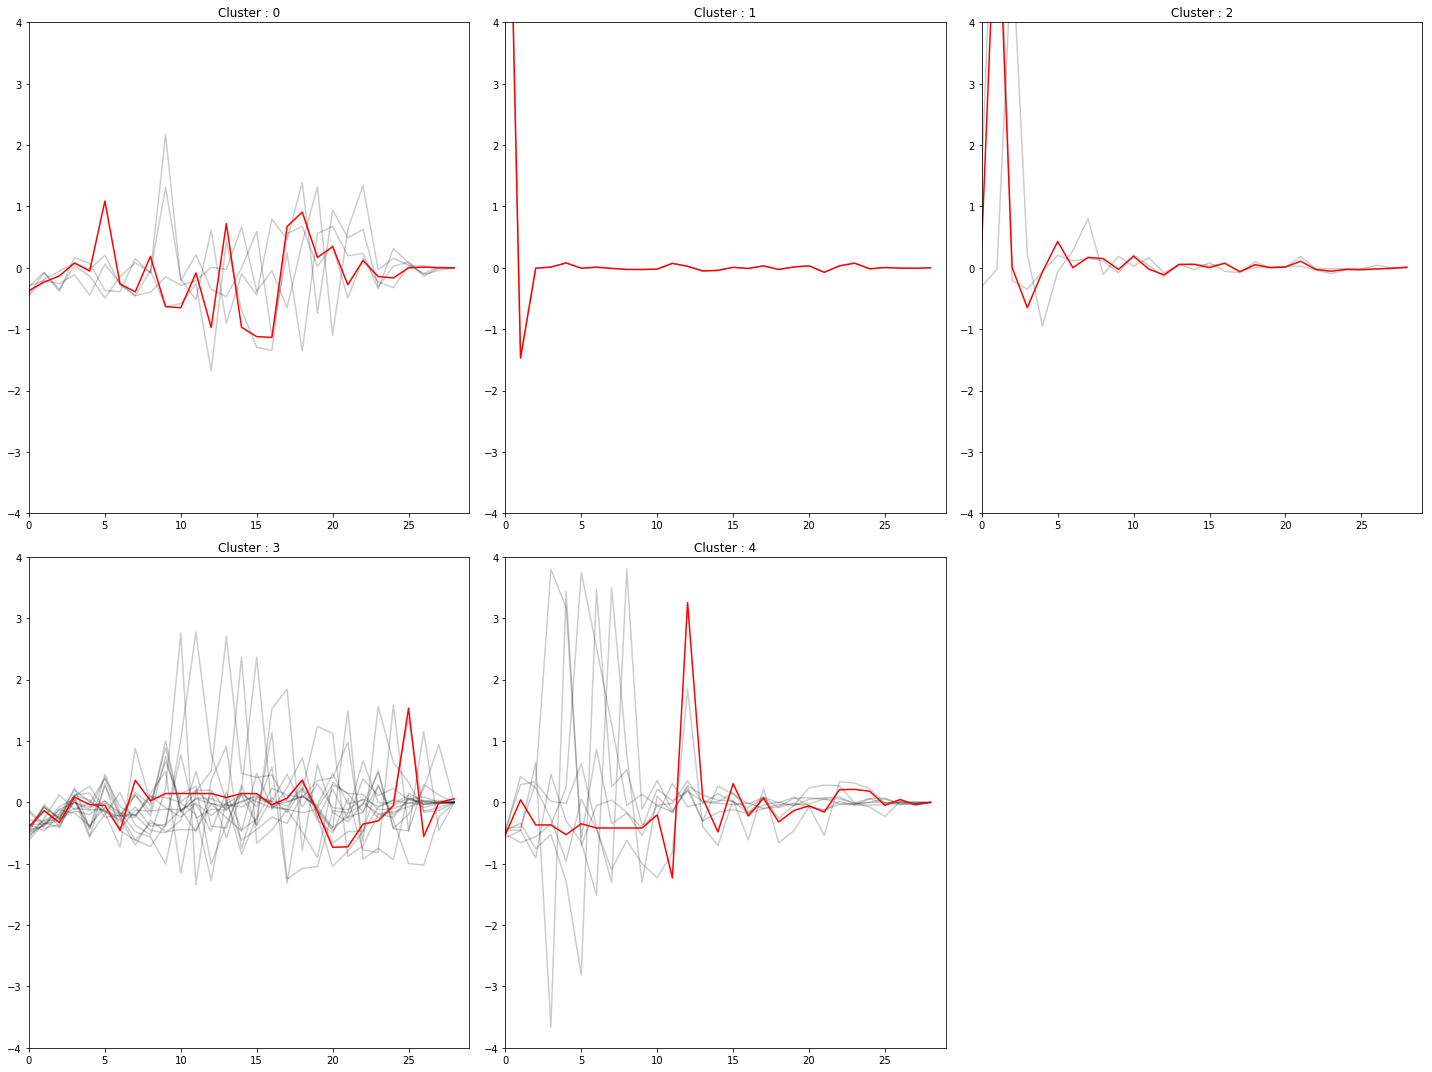

In [18]:
# Plot
plt.clf()
plt.rcParams['figure.figsize'] = [20, 15]
for yi in set(pred_clusters):
    plt.subplot(N_CLUSTERS/3 + 1, 3, yi + 1)
    for xx in training_data[pred_clusters == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, training_data.shape[1])
    plt.ylim(-4, 4)
    title = "Cluster : " + str(yi)
    plt.title(title)

plt.tight_layout()
plt.show()